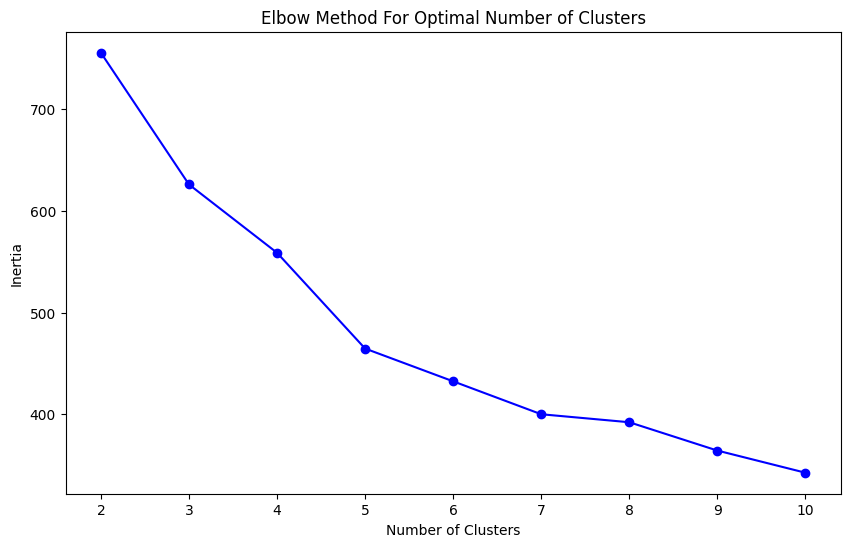

Davies-Bouldin Index: 1.3416333488796677


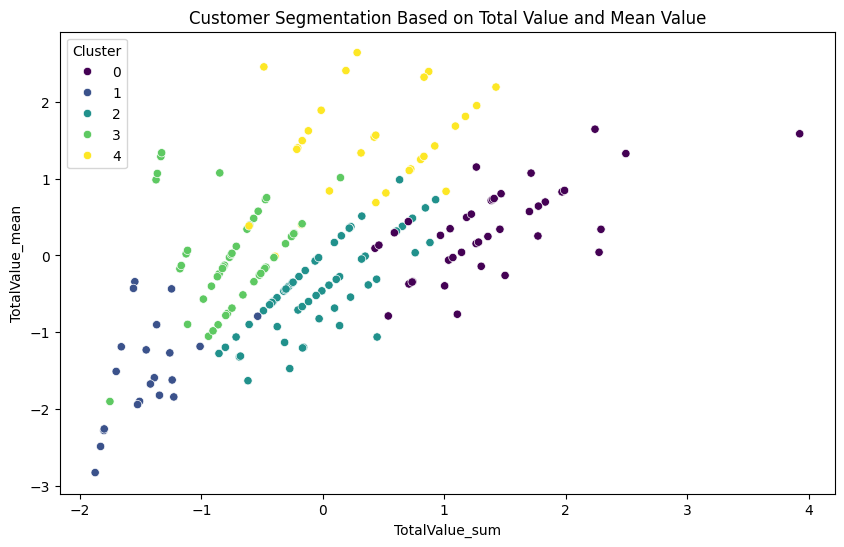

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions.csv")

In [ ]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [ ]:
transaction_features = transactions.groupby('CustomerID').agg({
 'TotalValue': ['sum', 'mean', 'count'],
 'Quantity': ['sum', 'mean']
}).reset_index()
transaction_features.columns = ['CustomerID', 'TotalValue_sum', 'TotalValue_mean', 'Transaction_count', 'Quantity_sum', 'Quantity_mean']

In [ ]:

customer_data = pd.merge(customers, transaction_features, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)
customer_data = pd.get_dummies(customer_data, columns=['Region'])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['TotalValue_sum', 'TotalValue_mean', 'Transaction_count', 'Quantity_sum', 'Quantity_mean']
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])

# Prepare data for clustering
X = customer_data.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(2, 11)
for k in K:
 kmeans = KMeans(n_clusters=k, random_state=42)
 kmeans.fit(X)
 inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

# Apply K-Means clustering with the chosen number of clusters
optimal_k = 5  # Choose based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the data
customer_data['Cluster'] = clusters

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalValue_sum', y='TotalValue_mean', hue='Cluster', data=customer_data, palette='viridis')
plt.title('Customer Segmentation Based on Total Value and Mean Value')
plt.show()

# # Optional: Save clustered data
# customer_data.to_csv("clustered_customers.csv", index=False)